In [297]:
import pandas as pd
import numpy as np
from collections import Counter
%config InlineBackend.figure_format = 'retina'
import graphviz
from IPython.display import display

def check_ifreal(y: pd.Series):
    """Check if the target variable is continuous or categorical."""
    if pd.api.types.is_float_dtype(y):
        return True
    if pd.api.types.is_string_dtype(y):
        return False
    if y.dtype.name == 'category':
        return False
    if pd.api.types.is_integer_dtype(y):
        # Explicitly check for categorical dtype
        # Check if the number of unique values is small
        if len(y.unique()) < 10:
            return False
    return True

class RegressionTree:
    def __init__(self, criterion='mse', max_depth=5):
        self.criterion = criterion
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X: pd.DataFrame, y: pd.Series, depth=0):
        """Recursively build the regression tree"""
        if depth == self.max_depth or len(y) < 2:
            return np.mean(y)

        # Find the best attribute and value to split on
        best_attr, best_value = self.opt_split_attribute(X, y)

        if best_attr is None:
            return np.mean(y)  # Return the mean if no valid split is found

        tree = {best_attr: {}}

        # Split the data based on the best attribute and value
        X_left, y_left, X_right, y_right = self.split_data(X, y, best_attr, best_value)

        # Recursively build the tree
        tree[best_attr]['<= {:.3f}'.format(best_value)] = self.fit(X_left, y_left, depth + 1)
        tree[best_attr]['> {:.3f}'.format(best_value)] = self.fit(X_right, y_right, depth + 1)

        self.tree = tree
        return tree

    def predict_one(self, x: pd.Series):
        """Predict a single sample by traversing the tree"""
        node = self.tree
        while isinstance(node, dict):
            attr = next(iter(node))
            if x[attr] <= float(next(iter(node[attr]))[3:]):
                node = node[attr]['<= {:.3f}'.format(float(next(iter(node[attr]))[3:]))]
            else:
                node = node[attr]['> {:.3f}'.format(float(next(iter(node[attr]))[3:]))]
        return node

    def predict(self, X: pd.DataFrame):
        """Traverse the tree to make predictions"""
        return np.array([self.predict_one(x) for _, x in X.iterrows()])

    def opt_split_attribute(self, X: pd.DataFrame, y: pd.Series):
        """Find the best attribute and value to split on based on the chosen criterion (MSE or Variance Reduction)."""
        best_gain = -float('inf')
        best_attr, best_value = None, None

        for feature in X.columns:
            values = sorted(X[feature].unique())
            # Check midpoints between consecutive values
            split_points = [(values[i] + values[i + 1]) / 2 for i in range(len(values) - 1)]

            for value in split_points:
                X_left, y_left, X_right, y_right = self.split_data(X, y, feature, value)
                gain = self.variance_reduction(y, y_left, y_right)

                if gain > best_gain:
                    best_gain = gain
                    best_attr, best_value = feature, value

        return best_attr, best_value

    def split_data(self, X: pd.DataFrame, y: pd.Series, attribute, value):
        """Split the data based on an attribute and its value."""
        mask = X[attribute] <= value
        return X[mask], y[mask], X[~mask], y[~mask]
        
    def variance_reduction(self, y, y_left, y_right):
        """Calculate the variance reduction or MSE reduction as a split criterion."""
        var_total = np.var(y)
        var_left = np.var(y_left)
        var_right = np.var(y_right)
        
        # Weighted average of the variance in the left and right splits
        weighted_var = (len(y_left) * var_left + len(y_right) * var_right) / len(y)
        
        return var_total - weighted_var
    
    def create_dot(self, tree_dict=None, node_id=0, parent=None, branch_label="", leaf_color="lightblue"):
        """Recursively convert the nested tree structure into DOT format with thresholds in the node labels."""
        if tree_dict is None:
            tree_dict = self.tree
    
        dot_string = ""
        current_node = f"node_{node_id}"
    
        # Base case: If it's a leaf node, return the value
        if not isinstance(tree_dict, dict):
            label = f"Output: {tree_dict:.3f}"
            dot_string += f'{current_node} [label="{label}", shape=ellipse, style=filled, fillcolor="{leaf_color}"];\n'
            if parent is not None:
                dot_string += f'{parent} -> {current_node} [label="{branch_label}"];\n'
            return dot_string, node_id
    
        # Recursive case: Iterate through the tree structure
        for feature, branches in tree_dict.items():
            true_threshold = None
            false_threshold = None
    
            # Separate the true and false branches and capture their thresholds
            for threshold, subtree in branches.items():
                if "<=" in threshold:
                    false_threshold = threshold
                    false_branch = subtree
                else:
                    true_threshold = threshold
                    true_branch = subtree
    
            # Create a label that includes the feature and both thresholds
            label = f"Column {feature}\\nValue {true_threshold}"
            dot_string += f'{current_node} [label="{label}"];\n'
    
            if parent is not None:
                dot_string += f'{parent} -> {current_node} [label="{branch_label}"];\n'
    
            # Recursively generate the true branch
            if true_branch is not None:
                node_id += 1
                subtree_str, node_id = self.create_dot(true_branch, node_id=node_id, parent=current_node, branch_label="True", leaf_color=leaf_color)
                dot_string += subtree_str
    
            # Recursively generate the false branch
            if false_branch is not None:
                node_id += 1
                subtree_str, node_id = self.create_dot(false_branch, node_id=node_id, parent=current_node, branch_label="False", leaf_color=leaf_color)
                dot_string += subtree_str
    
        return dot_string, node_id


    def plot(self, filename="tree"):
        """Generate and display the tree as a graph using Graphviz"""
        dot_string = "digraph G {\n"
        dot_tree, _ = self.create_dot(self.tree)
        dot_string += dot_tree
        dot_string += "}\n"

        # Render the tree using Graphviz
        graph = graphviz.Source(dot_string)
        graph.render(filename)  # Use the filename parameter
        #display(graph)  # Display in Jupyter Notebook

class ClassificationTreeRealInput:
    def __init__(self, criterion='gini_index', max_depth=5):
        self.criterion = criterion
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X: pd.DataFrame, y: pd.Series, depth=0):
        """Recursively build the classification tree"""
        if depth == self.max_depth or len(y.unique()) == 1:
            return Counter(y).most_common(1)[0][0]

        # Find the best attribute and value to split on
        best_attr, best_value = self.opt_split_attribute(X, y)

        if best_attr is None:
            return Counter(y).most_common(1)[0][0]

        tree = {best_attr: {}}

        # Split the data based on the best attribute and value
        X_left, y_left, X_right, y_right = self.split_data(X, y, best_attr, best_value)

        # Recursively build the tree
        tree[best_attr]['<= {:.3f}'.format(best_value)] = self.fit(X_left, y_left, depth + 1)
        tree[best_attr]['> {:.3f}'.format(best_value)] = self.fit(X_right, y_right, depth + 1)

        self.tree = tree
        return tree

    def predict_one(self, x: pd.Series):
        """Predict a single sample by traversing the tree"""
        node = self.tree
        while isinstance(node, dict):
            attr = next(iter(node))
            if x[attr] <= float(next(iter(node[attr]))[3:]):
                node = node[attr]['<= {:.3f}'.format(float(next(iter(node[attr]))[3:]))]
            else:
                node = node[attr]['> {:.3f}'.format(float(next(iter(node[attr]))[3:]))]
        return node

    def predict(self, X: pd.DataFrame):
        """Traverse the tree to make predictions"""
        return np.array([self.predict_one(x) for _, x in X.iterrows()])

    def opt_split_attribute(self, X: pd.DataFrame, y: pd.Series):
        """Find the best attribute and value to split on based on the chosen criterion."""
        best_gain = -float('inf')
        best_attr, best_value = None, None

        for feature in X.columns:
            values = sorted(X[feature].unique())
            # Check midpoints between consecutive values
            split_points = [(values[i] + values[i + 1]) / 2 for i in range(len(values) - 1)]

            for value in split_points:
                X_left, y_left, X_right, y_right = self.split_data(X, y, feature, value)
                gain = self.information_gain(y, y_left, y_right) if self.criterion == 'entropy' else self.gini_gain(y, y_left, y_right)

                if gain > best_gain:
                    best_gain = gain
                    best_attr, best_value = feature, value

        return best_attr, best_value

    def split_data(self, X: pd.DataFrame, y: pd.Series, attribute, value):
        """Split the data based on an attribute and its value."""
        mask = X[attribute] <= value
        return X[mask], y[mask], X[~mask], y[~mask]

    def gini_gain(self, y, y_left, y_right):
        """Calculate the Gini gain of a split."""
        total_gini = self.gini_index(y)
        weighted_gini = (len(y_left) * self.gini_index(y_left) + len(y_right) * self.gini_index(y_right)) / len(y)
        return total_gini - weighted_gini

    def gini_index(self, y):
        """Calculate the Gini index of a dataset."""
        counts = np.bincount(y)
        probabilities = counts / len(y)
        return 1 - np.sum([p ** 2 for p in probabilities])

    def information_gain(self, y, y_left, y_right):
        """Calculate the information gain of a split (using entropy)."""
        total_entropy = self.entropy(y)
        weighted_entropy = (len(y_left) * self.entropy(y_left) + len(y_right) * self.entropy(y_right)) / len(y)
        return total_entropy - weighted_entropy

    def entropy(self, y):
        """Calculate the entropy of a dataset."""
        counts = np.bincount(y)
        probabilities = counts / len(y)
        return -np.sum([p * np.log2(p) for p in probabilities if p > 0])
    
    def create_dot(self, tree_dict=None, node_id=0, parent=None, branch_label="", leaf_color="lightblue"):
        """Recursively convert the nested tree structure into DOT format with thresholds in the node labels."""
        if tree_dict is None:
            tree_dict = self.tree
    
        dot_string = ""
        current_node = f"node_{node_id}"
    
        # Base case: If it's a leaf node, return the value
        if not isinstance(tree_dict, dict):
            label = f"Output: {tree_dict:.3f}"
            dot_string += f'{current_node} [label="{label}", shape=ellipse, style=filled, fillcolor="{leaf_color}"];\n'
            if parent is not None:
                dot_string += f'{parent} -> {current_node} [label="{branch_label}"];\n'
            return dot_string, node_id
    
        # Recursive case: Iterate through the tree structure
        for feature, branches in tree_dict.items():
            true_threshold = None
            false_threshold = None
    
            # Separate the true and false branches and capture their thresholds
            for threshold, subtree in branches.items():
                if "<=" in threshold:
                    false_threshold = threshold
                    false_branch = subtree
                else:
                    true_threshold = threshold
                    true_branch = subtree
    
            # Create a label that includes the feature and both thresholds
            label = f"Column {feature}\\nValue {true_threshold}"
            dot_string += f'{current_node} [label="{label}"];\n'
    
            if parent is not None:
                dot_string += f'{parent} -> {current_node} [label="{branch_label}"];\n'
    
            # Recursively generate the true branch
            if true_branch is not None:
                node_id += 1
                subtree_str, node_id = self.create_dot(true_branch, node_id=node_id, parent=current_node, branch_label="True", leaf_color=leaf_color)
                dot_string += subtree_str
    
            # Recursively generate the false branch
            if false_branch is not None:
                node_id += 1
                subtree_str, node_id = self.create_dot(false_branch, node_id=node_id, parent=current_node, branch_label="False", leaf_color=leaf_color)
                dot_string += subtree_str
    
            return dot_string, node_id

    def plot(self, filename="tree"):
        """Generate and display the tree as a graph using Graphviz"""
        dot_string = "digraph G {\n"
        dot_tree, _ = self.create_dot(self.tree)
        dot_string += dot_tree
        dot_string += "}\n"

        # Render the tree using Graphviz
        graph = graphviz.Source(dot_string)
        graph.render(filename)  # Use the filename parameter
        #display(graph)  # Display in Jupyter Notebook

class ClassificationTree:
    def __init__(self, criterion='gini_index', max_depth=5):
        self.criterion = criterion
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X: pd.DataFrame, y: pd.Series, depth=0):
        """Recursively build the classification tree"""
        if len(y) == 0:
            return None 
        if depth == self.max_depth or len(y.unique()) == 1:
            return Counter(y).most_common(1)[0][0]

        # Find the best attribute to split on
        best_attr = self.opt_split_attribute(X, y)

        if best_attr is None:
            return Counter(y).most_common(1)[0][0]

        tree = {best_attr: {}}

        # Split the data based on the best attribute
        X_left, y_left, X_right, y_right = self.split_data(X, y, best_attr)

        # Recursively build the tree
        tree[best_attr][0] = self.fit(X_left, y_left, depth + 1)
        tree[best_attr][1] = self.fit(X_right, y_right, depth + 1)

        self.tree = tree
        return tree

    def predict_one(self, x: pd.Series):
        """Predict a single sample by traversing the tree"""
        node = self.tree
        while isinstance(node, dict):
            attr = next(iter(node))
            node = node[attr][x[attr]]
        return node

    def predict(self, X: pd.DataFrame):
        """Traverse the tree to make predictions"""
        return np.array([self.predict_one(x) for _, x in X.iterrows()])

    def opt_split_attribute(self, X: pd.DataFrame, y: pd.Series):
        """Find the best attribute to split on based on the chosen criterion."""
        best_gain = -float('inf')
        best_attr = None

        for feature in X.columns:
            X_left, y_left, X_right, y_right = self.split_data(X, y, feature)
            gain = self.information_gain(y, y_left, y_right) if self.criterion == 'entropy' else self.gini_gain(y, y_left, y_right)

            if gain > best_gain:
                best_gain = gain
                best_attr = feature

        return best_attr

    def split_data(self, X: pd.DataFrame, y: pd.Series, attribute):
        """Split the data based on an attribute"""
        mask = X[attribute] == 0
        return X[mask], y[mask], X[~mask], y[~mask]

    def gini_gain(self, y, y_left, y_right):
        """Calculate the Gini gain of a split."""
        total_gini = self.gini_index(y)
        weighted_gini = (len(y_left) * self.gini_index(y_left) + len(y_right) * self.gini_index(y_right)) / len(y)
        return total_gini - weighted_gini

    def gini_index(self, y):
        """Calculate the Gini index of a dataset."""
        counts = np.bincount(y)
        probabilities = counts / len(y)
        return 1 - np.sum([p ** 2 for p in probabilities])

    def information_gain(self, y, y_left, y_right):
        """Calculate the information gain of a split (using entropy)."""
        total_entropy = self.entropy(y)
        weighted_entropy = (len(y_left) * self.entropy(y_left) + len(y_right) * self.entropy(y_right)) / len(y)
        return total_entropy - weighted_entropy

    def entropy(self, y):
        """Calculate the entropy of a dataset."""
        counts = np.bincount(y)
        probabilities = counts / len(y)
        return -np.sum([p * np.log2(p) for p in probabilities if p > 0])

    def create_dot(self, tree_dict=None, node_id=0, parent=None, branch_label="", leaf_color="lightblue"):
        """
        Recursively convert the nested tree structure into DOT format with split index in the node labels.
        This version handles tree structures like {'0_0': {...}, ...} where keys are a combination of feature index and split index.
        """
        if tree_dict is None:
            tree_dict = self.tree
    
        dot_string = ""
        current_node = f"node_{node_id}"
    
        # Base case: If it's a leaf node, return the value
        if not isinstance(tree_dict, dict):
            label = f"Output: {tree_dict}"
            dot_string += f'{current_node} [label="{label}", shape="ellipse", style="filled", fillcolor="{leaf_color}"];\n'
            if parent is not None:
                dot_string += f'{parent} -> {current_node} [label="{branch_label}"];\n'
            return dot_string, node_id
    
        # Recursive case: Iterate through the tree structure
        for key, branches in tree_dict.items():
            feature, split_index = key.split('_')
            label = f"Column: {feature}\\nValue: {split_index}"
            dot_string += f'{current_node} [label="{label}", shape="box"];\n'

            if parent is not None:
                dot_string += f'{parent} -> {current_node} [label="{branch_label}"];\n'
    
            # Generate true branch (usually indexed by 0)
            if 0 in branches:
                node_id += 1
                subtree_str, node_id = self.create_dot(branches[0], node_id=node_id, parent=current_node, branch_label="True", leaf_color=leaf_color)
                dot_string += subtree_str
    
            # Generate false branch (usually indexed by 1)
            if 1 in branches:
                node_id += 1
                subtree_str, node_id = self.create_dot(branches[1], node_id=node_id, parent=current_node, branch_label="False", leaf_color=leaf_color)
                dot_string += subtree_str
    
        return dot_string, node_id

    def plot(self, filename="tree"):
        """Generate and display the tree as a graph using Graphviz"""
        dot_string = "digraph G {\n"
        dot_tree, _ = self.create_dot(self.tree)
        dot_string += dot_tree
        dot_string += "}\n"

        # Render the tree using Graphviz
        graph = graphviz.Source(dot_string)
        graph.render(filename)  # Use the filename parameter
        #display(graph)  # Display in Jupyter Notebook

In [299]:
"""
The current code given is for the Assignment 1.
You will be expected to use this to make trees for:
> discrete input, discrete output
> real input, real output
> real input, discrete output
> discrete input, real output
"""
from dataclasses import dataclass
from typing import Literal

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from tree.utils import *

np.random.seed(42)

from dataclasses import dataclass
from typing import Literal

@dataclass
class DecisionTree:
    criterion: Literal["information_gain", "gini_index", "mse"]  # criterion will vary based on tree type
    max_depth: int  # The maximum depth the tree can grow to
    tree: object = None  # The actual tree (ClassificationTree, RegressionTree, etc.)
    filename: str = "Decision_tree"

    def __init__(self, criterion='gini_index', max_depth=5):
        self.criterion = criterion
        self.max_depth = max_depth
        self.filename=filename

    def fit(self, X: pd.DataFrame, y: pd.Series) -> None:
        """
        Function to train and construct the decision tree
        """
        X_is_real = check_ifreal(pd.concat([X[col] for col in X.columns[1:]], ignore_index=True)) 
        y_is_real = check_ifreal(y) 

        if X_is_real:
            if y_is_real:
                self.tree = RegressionTree(criterion='mse', max_depth=self.max_depth)
            else:
                self.tree = ClassificationTreeRealInput(criterion=self.criterion, max_depth=self.max_depth)
            self.tree.fit(X, y)
        else:  
            if y_is_real:
                self.tree = RegressionTree(criterion='mse', max_depth=self.max_depth)
            else:
                self.tree = ClassificationTree(criterion=self.criterion, max_depth=self.max_depth)
            self.tree.fit(X, y)
            
        

    def predict(self, X: pd.DataFrame) -> pd.Series:
        """
        Function to run the decision tree on test inputs
        """
        return self.tree.predict(X)

    def plot(self, filename) -> None:
        """
        Function to plot the tree
        """
        self.tree.plot(filename)

In [301]:
from typing import Union

def accuracy(y_hat: pd.Series, y: pd.Series) -> float:
    """
    Function to calculate the accuracy.
    Accuracy = (Number of correct predictions) / (Total number of predictions)
    """
    assert y_hat.size == y.size, "y_hat and y must have the same size"
    
    correct_predictions = 0
    total_predictions = y.size

    for i in range(total_predictions):
        if y_hat[i] == y[i]:
            correct_predictions += 1

    return correct_predictions / total_predictions

def precision(y_hat: pd.Series, y: pd.Series, cls: Union[int, str]) -> float:
    """
    Function to calculate the precision.
    Precision = (True Positives) / (True Positives + False Positives)
    """
    true_positives = 0
    false_positives = 0

    for i in range(y.size):
        if y_hat[i] == cls:
            if y[i] == cls:
                true_positives += 1
            else:
                false_positives += 1

    if true_positives + false_positives == 0:
        return 0.0  # Avoid division by zero

    return true_positives / (true_positives + false_positives)

def recall(y_hat: pd.Series, y: pd.Series, cls: Union[int, str]) -> float:
    """
    Function to calculate the recall.
    Recall = (True Positives) / (True Positives + False Negatives)
    """
    true_positives = 0
    false_negatives = 0

    for i in range(y.size):
        if y[i] == cls:
            if y_hat[i] == cls:
                true_positives += 1
            else:
                false_negatives += 1

    if true_positives + false_negatives == 0:
        return 0.0  # Avoid division by zero

    return true_positives / (true_positives + false_negatives)

import math

def rmse(y_hat: pd.Series, y: pd.Series) -> float:
    """
    Function to calculate the root-mean-squared-error (RMSE).
    RMSE = sqrt((1/N) * sum((y_hat - y)^2))
    """
    assert y_hat.size == y.size, "y_hat and y must have the same size"

    sum_squared_errors = 0.0
    n = y.size

    for i in range(n):
        error = y_hat[i] - y[i]
        sum_squared_errors += error ** 2

    mean_squared_error = sum_squared_errors / n
    return math.sqrt(mean_squared_error)

def mae(y_hat: pd.Series, y: pd.Series) -> float:
    """
    Function to calculate the mean-absolute-error (MAE).
    MAE = (1/N) * sum(|y_hat - y|)
    """
    assert y_hat.size == y.size, "y_hat and y must have the same size"

    sum_absolute_errors = 0.0
    n = y.size

    for i in range(n):
        error = abs(y_hat[i] - y[i])
        sum_absolute_errors += error

    return sum_absolute_errors / n


In [303]:
# Test case 1
# Real Input and Real Output

import pandas as pd
import numpy as np

N = 30
P = 5
X = pd.DataFrame(np.random.randn(N, P))
y = pd.Series(np.random.randn(N))

for i, criteria in enumerate(["information_gain", "gini_index"]):
    tree = DecisionTree(criterion=criteria)
    tree.fit(X, y)
    y_hat = tree.predict(X)
    filename = f"testcase1_tree_{i}_{criteria}"
    tree.plot(filename=filename)
    print("Criteria:", criteria)
    print("RMSE: ", rmse(y_hat, y))
    print("MAE: ", mae(y_hat, y))


Criteria: information_gain
RMSE:  0.3601329774475513
MAE:  0.24067253750418457
Criteria: gini_index
RMSE:  0.3601329774475513
MAE:  0.24067253750418457


In [306]:
# Test case 2
# Real Input and Discrete Output

import pandas as pd
import numpy as np
N = 30
P = 5
X = pd.DataFrame(np.random.randn(N, P))
y = pd.Series(np.random.randint(P, size=N), dtype="category")

for i, criteria in enumerate(["information_gain", "gini_index"]):
    tree = DecisionTree(criterion=criteria)  
    tree.fit(X, y)  # Fit the tree to the data
    y_hat = tree.predict(X)  # Make predictions
    filename = f"testcase2_tree_{i}_{criteria}"  # Define a unique filename for the plot
    tree.plot(filename=filename)  # Plot the decision tree
    
    # Print evaluation metrics
    print("Criteria:", criteria)
    print("Accuracy:", accuracy(y_hat, y))
    for cls in y.unique():
        print(f"Precision for class {cls}:", precision(y_hat, y, cls))
        print(f"Recall for class {cls}:", recall(y_hat, y, cls))


Criteria: information_gain
Accuracy: 0.8666666666666667
Precision for class 4: 1.0
Recall for class 4: 0.9
Precision for class 1: 0.7142857142857143
Recall for class 1: 1.0
Precision for class 2: 1.0
Recall for class 2: 0.8
Precision for class 3: 1.0
Recall for class 3: 1.0
Precision for class 0: 1.0
Recall for class 0: 0.3333333333333333
Criteria: gini_index
Accuracy: 0.8666666666666667
Precision for class 4: 1.0
Recall for class 4: 0.9
Precision for class 1: 0.7142857142857143
Recall for class 1: 1.0
Precision for class 2: 1.0
Recall for class 2: 0.8
Precision for class 3: 1.0
Recall for class 3: 1.0
Precision for class 0: 1.0
Recall for class 0: 0.3333333333333333


In [310]:
# Test case 3
# Discrete Input and Discrete Output

N = 30
P = 5
X = pd.DataFrame({i: pd.Series(np.random.randint(P, size=N), dtype="category") for i in range(P)})
y = pd.Series(np.random.randint(P, size=N), dtype="category")

# One-hot encode the categorical features
X = pd.get_dummies(X, dtype=int)

# Iterate over different criteria
for i, criteria in enumerate(["information_gain", "gini_index"]):
    tree = DecisionTree(criterion=criteria)  # Initialize the tree with the current criterion
    tree.fit(X, y)  # Fit the tree to the data
    y_hat = tree.predict(X)  # Make predictions
    filename = f"testcase3_tree_{i}_{criteria}"  # Define a unique filename for the plot
    tree.plot(filename=filename)  # Plot the decision tree
    
    # Print evaluation metrics
    print("Criteria:", criteria)
    print("Accuracy:", accuracy(y_hat, y))
    for cls in y.unique():
        print(f"Precision for class {cls}:", precision(y_hat, y, cls))
        print(f"Recall for class {cls}:", recall(y_hat, y, cls))

Criteria: information_gain
Accuracy: 0.8
Precision for class 1: 1.0
Recall for class 1: 1.0
Precision for class 3: 0.7142857142857143
Recall for class 3: 0.8333333333333334
Precision for class 4: 0.5555555555555556
Recall for class 4: 1.0
Precision for class 0: 1.0
Recall for class 0: 0.5
Precision for class 2: 1.0
Recall for class 2: 0.8333333333333334
Criteria: gini_index
Accuracy: 0.8
Precision for class 1: 1.0
Recall for class 1: 1.0
Precision for class 3: 0.7142857142857143
Recall for class 3: 0.8333333333333334
Precision for class 4: 0.5555555555555556
Recall for class 4: 1.0
Precision for class 0: 1.0
Recall for class 0: 0.5
Precision for class 2: 1.0
Recall for class 2: 0.8333333333333334


In [312]:
# Test case 4
# Discrete Input and Real Output

N = 30
P = 5
X = pd.DataFrame({i: pd.Series(np.random.randint(P, size=N), dtype="category") for i in range(P)})
y = pd.Series(np.random.randn(N))

# One-hot encode the categorical features
X = pd.get_dummies(X, dtype=int)

# Iterate over different criteria
for i, criteria in enumerate(["information_gain", "gini_index"]):
    tree = DecisionTree(criterion=criteria)  # Initialize the tree with the current criterion
    tree.fit(X, y)  # Fit the tree to the data
    y_hat = tree.predict(X)  # Make predictions
    filename = f"testcase4_tree_{i}_{criteria}"  # Define a unique filename for the plot
    tree.plot(filename=filename)  # Plot the decision tree
    
    # Print evaluation metrics
    print("Criteria:", criteria)
    print("RMSE:", rmse(y_hat, y))
    print("MAE:", mae(y_hat, y))

Criteria: information_gain
RMSE: 0.4505624073297307
MAE: 0.2542168089489226
Criteria: gini_index
RMSE: 0.4505624073297307
MAE: 0.2542168089489226


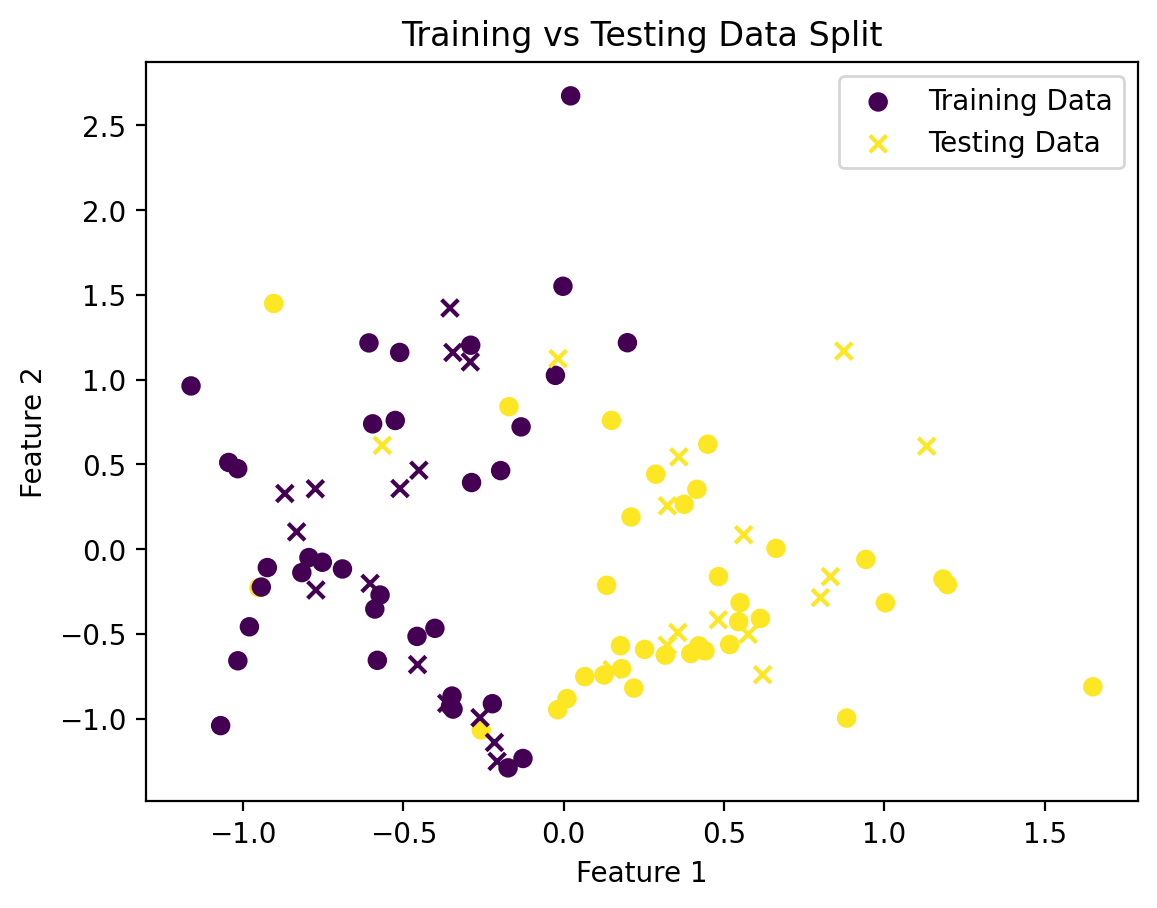

In [314]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=2, class_sep=0.5
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, marker='o', label='Training Data')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker='x', label='Testing Data')
plt.legend()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Training vs Testing Data Split')
plt.show()

In [316]:
tree = DecisionTree()  
X_train_df= pd.DataFrame(X_train)
y_train_df= pd.Series(y_train)
y_test_df= pd.Series(y_test)
X_test_df= pd.DataFrame(X_test)
tree.fit(X_train_df, y_train_df)
y_hat = tree.predict(X_test_df)

In [320]:
tree.plot("Q2a_tree")
print("Criteria :", criteria)
print("Accuracy: ", accuracy(y_hat, y_test_df))
for cls in y_test_df.unique():
    print("Precision: ", precision(y_hat, y_test_df, cls))
    print("Recall: ", recall(y_hat, y_test_df, cls))

Criteria : gini_index
Accuracy:  0.8333333333333334
Precision:  0.8571428571428571
Recall:  0.8
Precision:  0.8125
Recall:  0.8666666666666667


In [322]:
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd

# Assuming DecisionTree, accuracy, precision, and recall functions are already defined

# Initialize the KFold with 5 splits
kf = KFold(5)

# Variables for storing the optimal max depth and its corresponding accuracy
opt_max_depth = 0
opt_accuracy = 0

# Get the split data for cross-validation
splt_data = list(kf.split(X_train_df))

# Loop over different max_depth values
for max_depth in range(0, 9):
    avg_acc = 0
    
    # Perform cross-validation
    for train_ind, val_ind in splt_data:
        tree = DecisionTree(max_depth=max_depth)
        tree.fit(X_train_df.iloc[train_ind], y_train_df.iloc[train_ind])
        y_val_hat = tree.predict(X_train_df.iloc[val_ind])
        
        # Convert to NumPy array to avoid index issues
        acc = accuracy(y_val_hat, y_train_df.iloc[val_ind].values)
        avg_acc += acc / 5  # Average accuracy over the 5 folds
    
    # Check if this max_depth is the best so far
    if np.round(opt_accuracy, decimals=10) < np.round(avg_acc, decimals=10):
        opt_max_depth = max_depth
        opt_accuracy = avg_acc

# Output the optimal max depth and corresponding accuracy
print("Optimum Max depth is {}".format(opt_max_depth))
print("The average accuracy over validation data for max_depth {} is:- {}".format(opt_max_depth, opt_accuracy))

# Train the decision tree on the entire training dataset with the optimal max depth
tree = DecisionTree(max_depth=opt_max_depth)
tree.fit(X_train_df, y_train_df)

# Make predictions on the test data
y_hat = tree.predict(X_test_df)

# Output the evaluation metrics
print("After changing max_depth to {}".format(opt_max_depth))
print("Accuracy :- {}".format(accuracy(y_hat, y_test_df.values)))
print("Precision :- ")
print("            For y=1 :- {}".format(precision(y_hat, y_test_df.values, 1)))
print("            For y=0 :- {}".format(precision(y_hat, y_test_df.values, 0)))
print("Recall :- ")
print("            For y=1 :- {}".format(recall(y_hat, y_test_df.values, 1)))
print("            For y=0 :- {}".format(recall(y_hat, y_test_df.values, 0)))


Optimum Max depth is 2
The average accuracy over validation data for max_depth 2 is:- 0.8714285714285714
After changing max_depth to 2
Accuracy :- 0.9
Precision :- 
            For y=1 :- 1.0
            For y=0 :- 0.8333333333333334
Recall :- 
            For y=1 :- 0.8
            For y=0 :- 1.0


In [ ]:
pip install ucimlrepo

In [324]:
from ucimlrepo import fetch_ucirepo 

# fetch dataset 
auto_mpg = fetch_ucirepo(id=9) 
  
# data (as pandas dataframes) 
X = auto_mpg.data.features 
y = auto_mpg.data.targets 
X

,displacement,cylinders,horsepower,weight,acceleration,model_year,origin
0,307.0,8,130.0,3504,12.0,70,1
1,350.0,8,165.0,3693,11.5,70,1
2,318.0,8,150.0,3436,11.0,70,1
3,304.0,8,150.0,3433,12.0,70,1
4,302.0,8,140.0,3449,10.5,70,1
...,...,...,...,...,...,...,...
393,140.0,4,86.0,2790,15.6,82,1
394,97.0,4,52.0,2130,24.6,82,2
395,135.0,4,84.0,2295,11.6,82,1
396,120.0,4,79.0,2625,18.6,82,1


In [326]:
y

,mpg
0,18.0
1,15.0
2,18.0
3,16.0
4,17.0
...,...
393,27.0
394,44.0
395,32.0
396,28.0


In [328]:
tree = DecisionTree() 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#X_train, y_train
y_train= pd.Series(y_train.squeeze())
tree.fit(X_train,y_train)
y_pred = tree.predict(X_test)
y_test= pd.Series(y_test.squeeze())
y_pred= pd.Series(y_pred)

In [330]:
tree.plot("Q3a_tree")
# Ensure indices of y_pred and y_test match
y_pred = y_pred.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
# Now calculate RMSE
print("RMSE: ", rmse(y_pred, y_test))

RMSE:  3.3729035489847257


In [334]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn import tree 
import matplotlib.pyplot as plt

model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Root Mean Squared Error: {mse**0.5}")

# Plot the tree
plt.figure(figsize=(20,10))
plot_tree(model, filled=True, feature_names=X.columns, rounded=True)
plt.title("Decision Tree Regressor")
plt.savefig("Q3b_tree.png")
print(f"Depth of the decision tree: {model.get_depth()}")
plt.close()

Root Mean Squared Error: 3.673894391514269
Depth of the decision tree: 17


In [337]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn import tree 
import matplotlib.pyplot as plt

model = DecisionTreeRegressor(max_depth=5, random_state=42) # using a tree of same max_depth as our custom decision tree
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Root Mean Squared Error: {mse**0.5}")

# Plot the tree
plt.figure(figsize=(20,10))
plot_tree(model, filled=True, feature_names=X.columns, rounded=True)
plt.title("Decision Tree Regressor")
plt.savefig("Q3b_tree(depth=5).png")
print(f"Depth of the decision tree: {model.get_depth()}")
plt.close()

Root Mean Squared Error: 3.425725962236937
Depth of the decision tree: 5


Training Complexity: Typically O(N⋅MlogN) for decision trees, where N is the number of samples and M is the number of features.

Prediction Complexity: Typically O(logN) for decision trees.

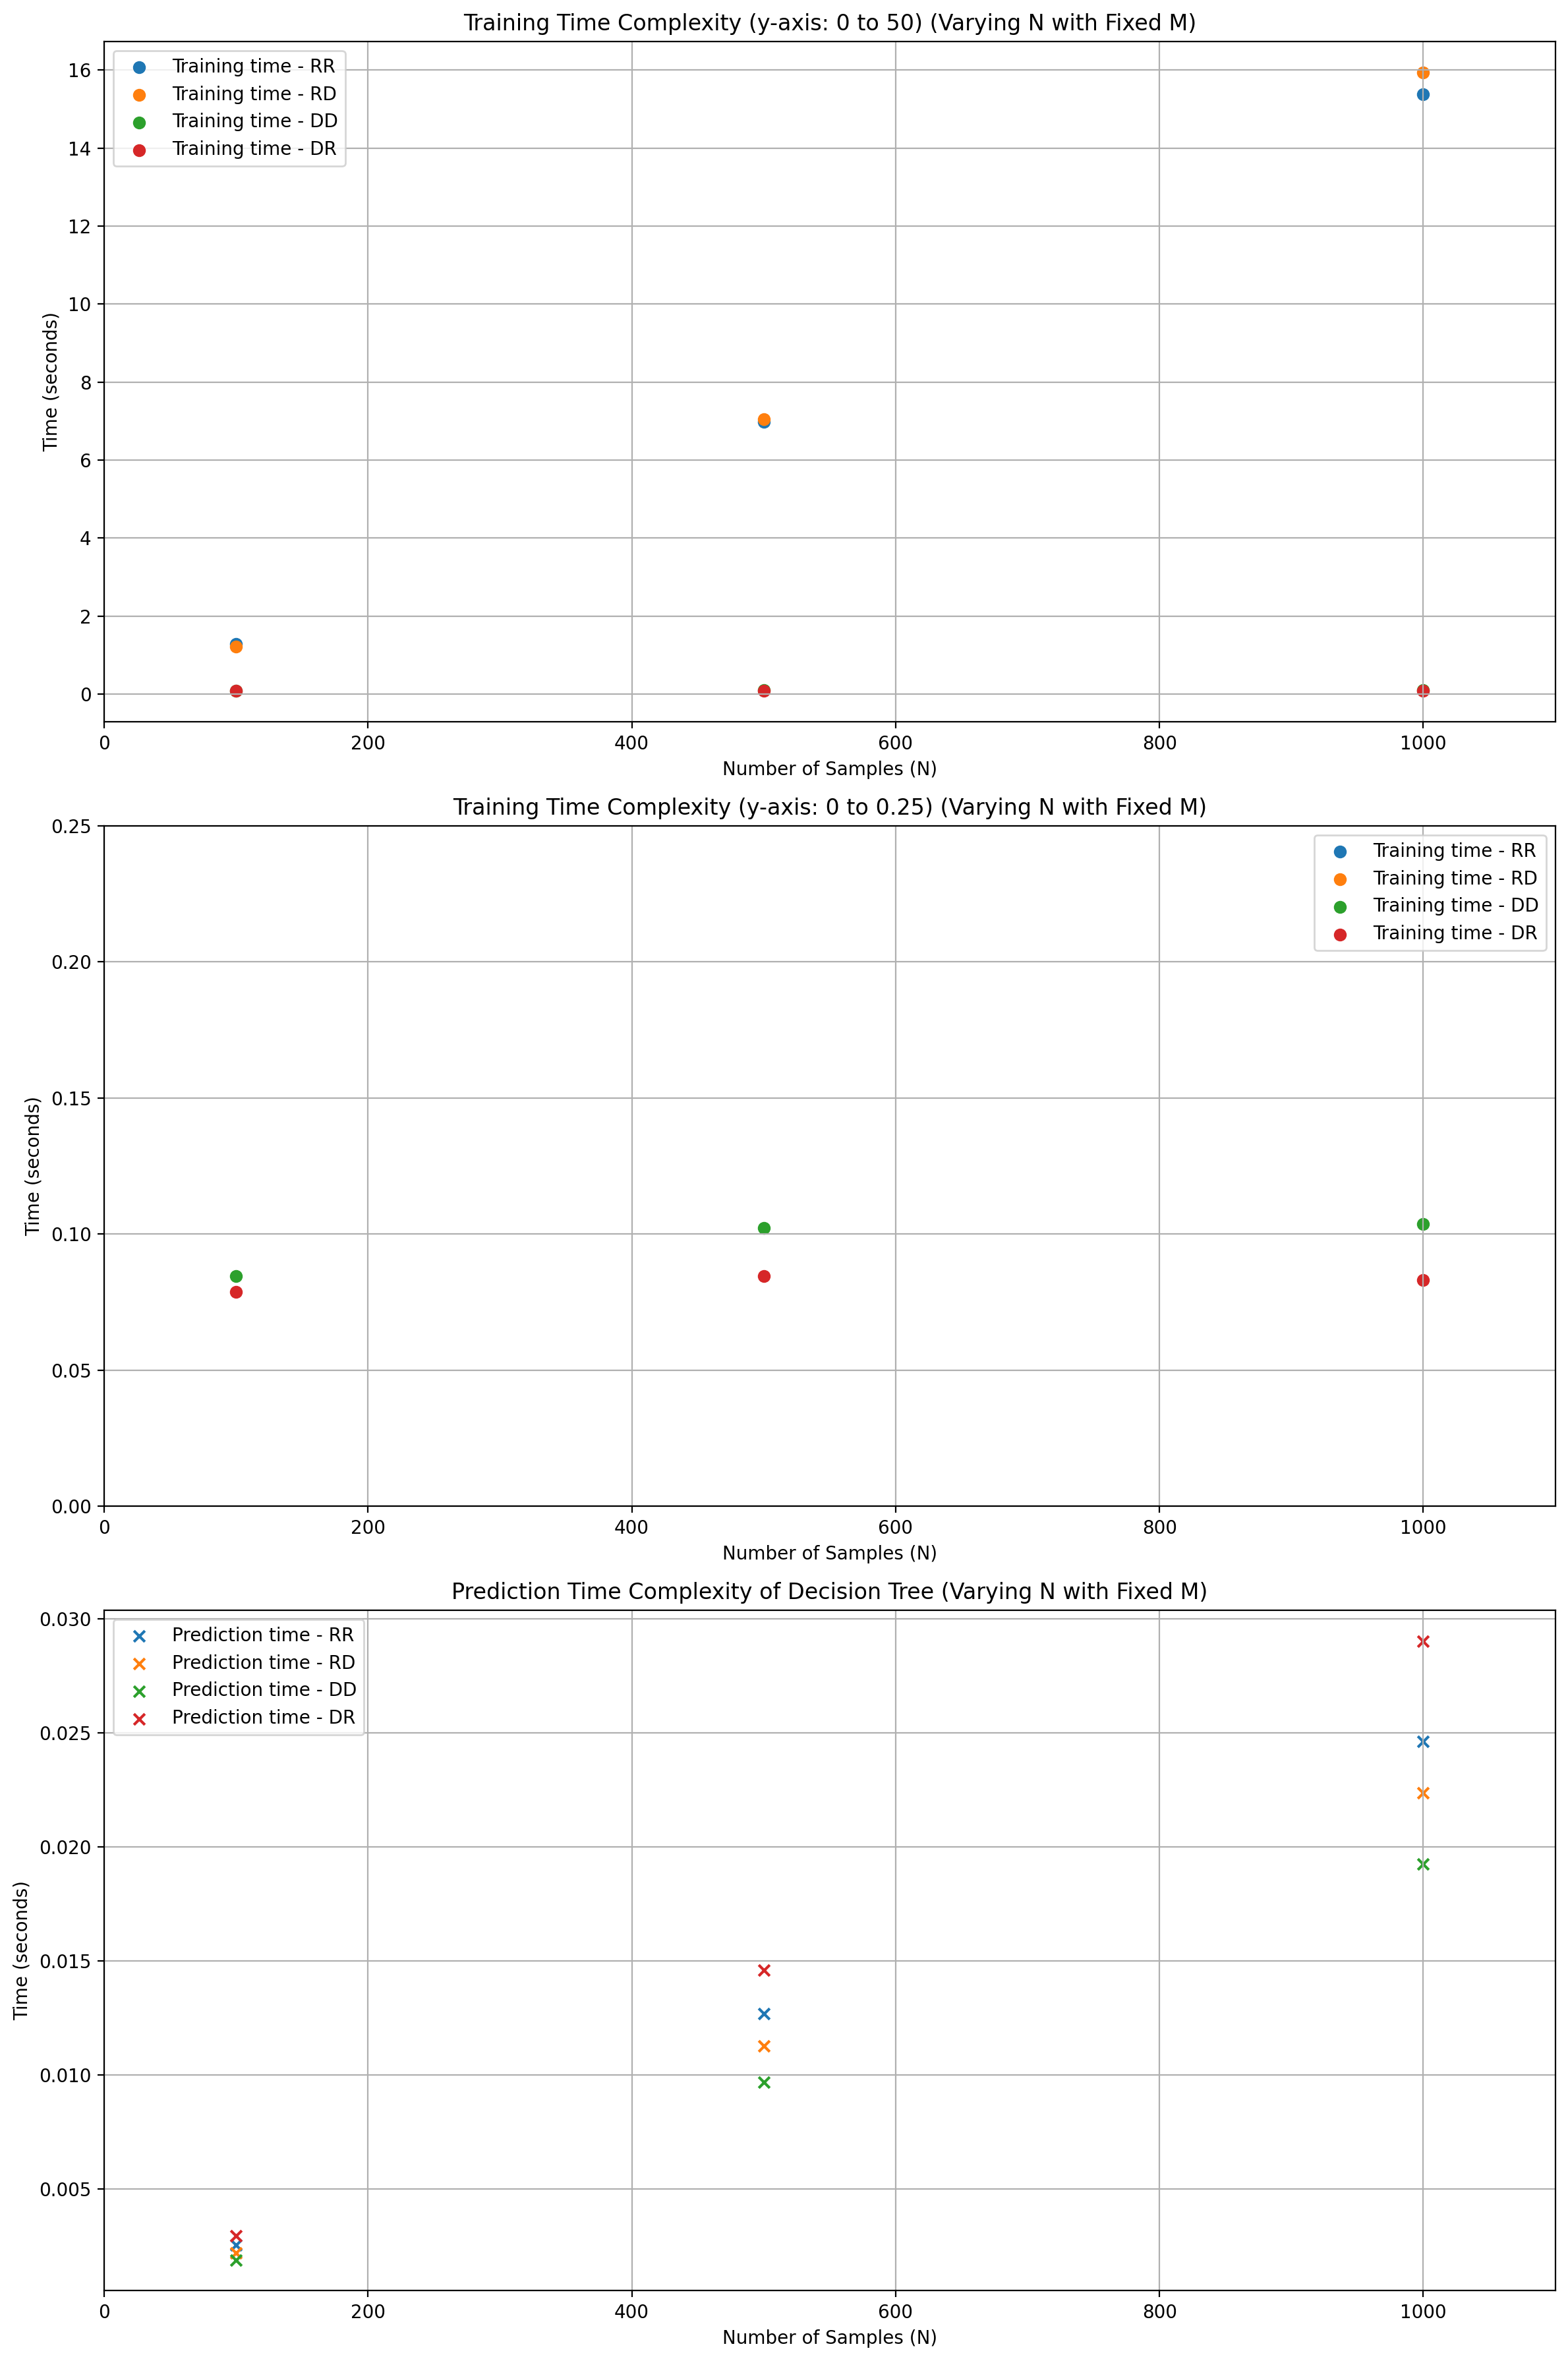

In [804]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

# Define N and M with appropriate ranges
N_values = [100, 500, 1000]
M_values = [10]  # Keeping M fixed for this plot

# Initialize dictionaries to store training and prediction times
train_times = {'RR': [], 'RD': [], 'DD': [], 'DR': []}
predict_times = {'RR': [], 'RD': [], 'DD': [], 'DR': []}

# Loop over different values of N
for N in N_values:
    M = M_values[0]  # Fix M
    
    # Lists to store times for three iterations
    train_times_iter = {'RR': [], 'RD': [], 'DD': [], 'DR': []}
    predict_times_iter = {'RR': [], 'RD': [], 'DD': [], 'DR': []}

    for _ in range(3):  # Run the experiments three times
        # Generate datasets
        X_real = pd.DataFrame(np.random.randn(N, M))  # Real inputs
        y_real = pd.Series(np.random.randn(N))  # Real outputs
        X_discrete = pd.DataFrame(np.random.randint(0, 2, size=(N, M)))  # Discrete inputs
        y_discrete = pd.Series(np.random.randint(0, 2, size=N))  # Discrete outputs

        # Initialize the DecisionTree objects for each case
        tree_rr = DecisionTree(criterion='mse', max_depth=5)  # Real input, Real output
        tree_rd = DecisionTree(criterion='gini', max_depth=5)  # Real input, Discrete output
        tree_dd = DecisionTree(criterion='gini', max_depth=5)  # Discrete input, Discrete output
        tree_dr = DecisionTree(criterion='mse', max_depth=5)  # Discrete input, Real output

        # Measure training time
        start_time = time.time()
        tree_rr.fit(X_real, y_real)
        train_times_iter['RR'].append(time.time() - start_time)

        start_time = time.time()
        tree_rd.fit(X_real, y_discrete)
        train_times_iter['RD'].append(time.time() - start_time)

        start_time = time.time()
        tree_dd.fit(X_discrete, y_discrete)
        train_times_iter['DD'].append(time.time() - start_time)

        start_time = time.time()
        tree_dr.fit(X_discrete, y_real)
        train_times_iter['DR'].append(time.time() - start_time)

        # Measure prediction time
        start_time = time.time()
        tree_rr.predict(X_real)
        predict_times_iter['RR'].append(time.time() - start_time)

        start_time = time.time()
        tree_rd.predict(X_real)
        predict_times_iter['RD'].append(time.time() - start_time)

        start_time = time.time()
        tree_dd.predict(X_discrete)
        predict_times_iter['DD'].append(time.time() - start_time)

        start_time = time.time()
        tree_dr.predict(X_discrete)
        predict_times_iter['DR'].append(time.time() - start_time)
    
    # Calculate the mean of three iterations and store it
    for key in train_times.keys():
        train_times[key].append(np.mean(train_times_iter[key]))
        predict_times[key].append(np.mean(predict_times_iter[key]))
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

# Create a figure with three subplots
plt.figure(figsize=(12, 18))

# Plot training times (y-axis: 0 to 0.25)
plt.subplot(3, 1, 2)
for key in train_times.keys():
    plt.scatter(N_values, train_times[key], label=f'Training time - {key}', marker='o')
plt.xlabel('Number of Samples (N)')
plt.ylabel('Time (seconds)')
plt.title('Training Time Complexity (y-axis: 0 to 0.25) (Varying N with Fixed M)')
plt.xlim(0, 1100)  # Adjust x-axis limits to fit N values
plt.ylim(0, 0.25)  # Set y-axis limits
plt.legend()
plt.grid(True)

# Plot training times (y-axis: 0 to 50)
plt.subplot(3, 1, 1)
for key in train_times.keys():
    plt.scatter(N_values, train_times[key], label=f'Training time - {key}', marker='o')
plt.xlabel('Number of Samples (N)')
plt.ylabel('Time (seconds)')
plt.title('Training Time Complexity (y-axis: 0 to 50) (Varying N with Fixed M)')
plt.xlim(0, 1100)  # Adjust x-axis limits to fit N values
#plt.ylim(0, 20)  # Set y-axis limits
plt.legend()
plt.grid(True)

# Plot prediction times
plt.subplot(3, 1, 3)
for key in predict_times.keys():
    plt.scatter(N_values, predict_times[key], label=f'Prediction time - {key}', marker='x')
plt.xlabel('Number of Samples (N)')
plt.ylabel('Time (seconds)')
plt.title('Prediction Time Complexity of Decision Tree (Varying N with Fixed M)')
plt.xlim(0, 1100)  # Adjust x-axis limits to fit N values
plt.legend()
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


__Constant M:__

**Training Time:**
As seen above the training time take for __real inputs__ case almost follows the order Nlog(N). From 100 samples to 500 samples, the training time changes from ~1 secs to ~7 secs(5log(500/log(100)=6.75). Same applies from 500 samples to 1000 samples, there is change from ~7secs to ~16secs(2log(1000)/log(500)=2.23). From 100 samples to 1000 samples, there is an increase of almost 15 secs which is consistent with O(Nlog(N)

For __discrete inputs__ the time take remains almost same, although there is an increase from 100 to 500 samples, but it is almost constant from 500 to 1000 samples. 

Interestingly, it can be seen that the time taken in a **decreasing order is as follows: RD >~ RR > DD > DR**. For the same input class, discrete output takes more time to train. 

**Prediction Time:**
Time taken for predicitons shows consistent trends for all the 4 cases. It increases ~7 times from N=100 to N=500, and double from N=500 to N=1000, as can be cleary seen from the graphs. 

Interestingly, it can be seen that the time taken in a **decreasing order is as follows: DR > RR > RD > DD**. Predicting real outputs(regressioon problems) take more time than for categorical data.

**Overall:**
Training time follows **O(Nlog(N))** for constant M for real inputs but not for discrete inputs.
Prediction time follows **O(log(N))** for constant M for all the 4 cases, consistent with theoretical results.

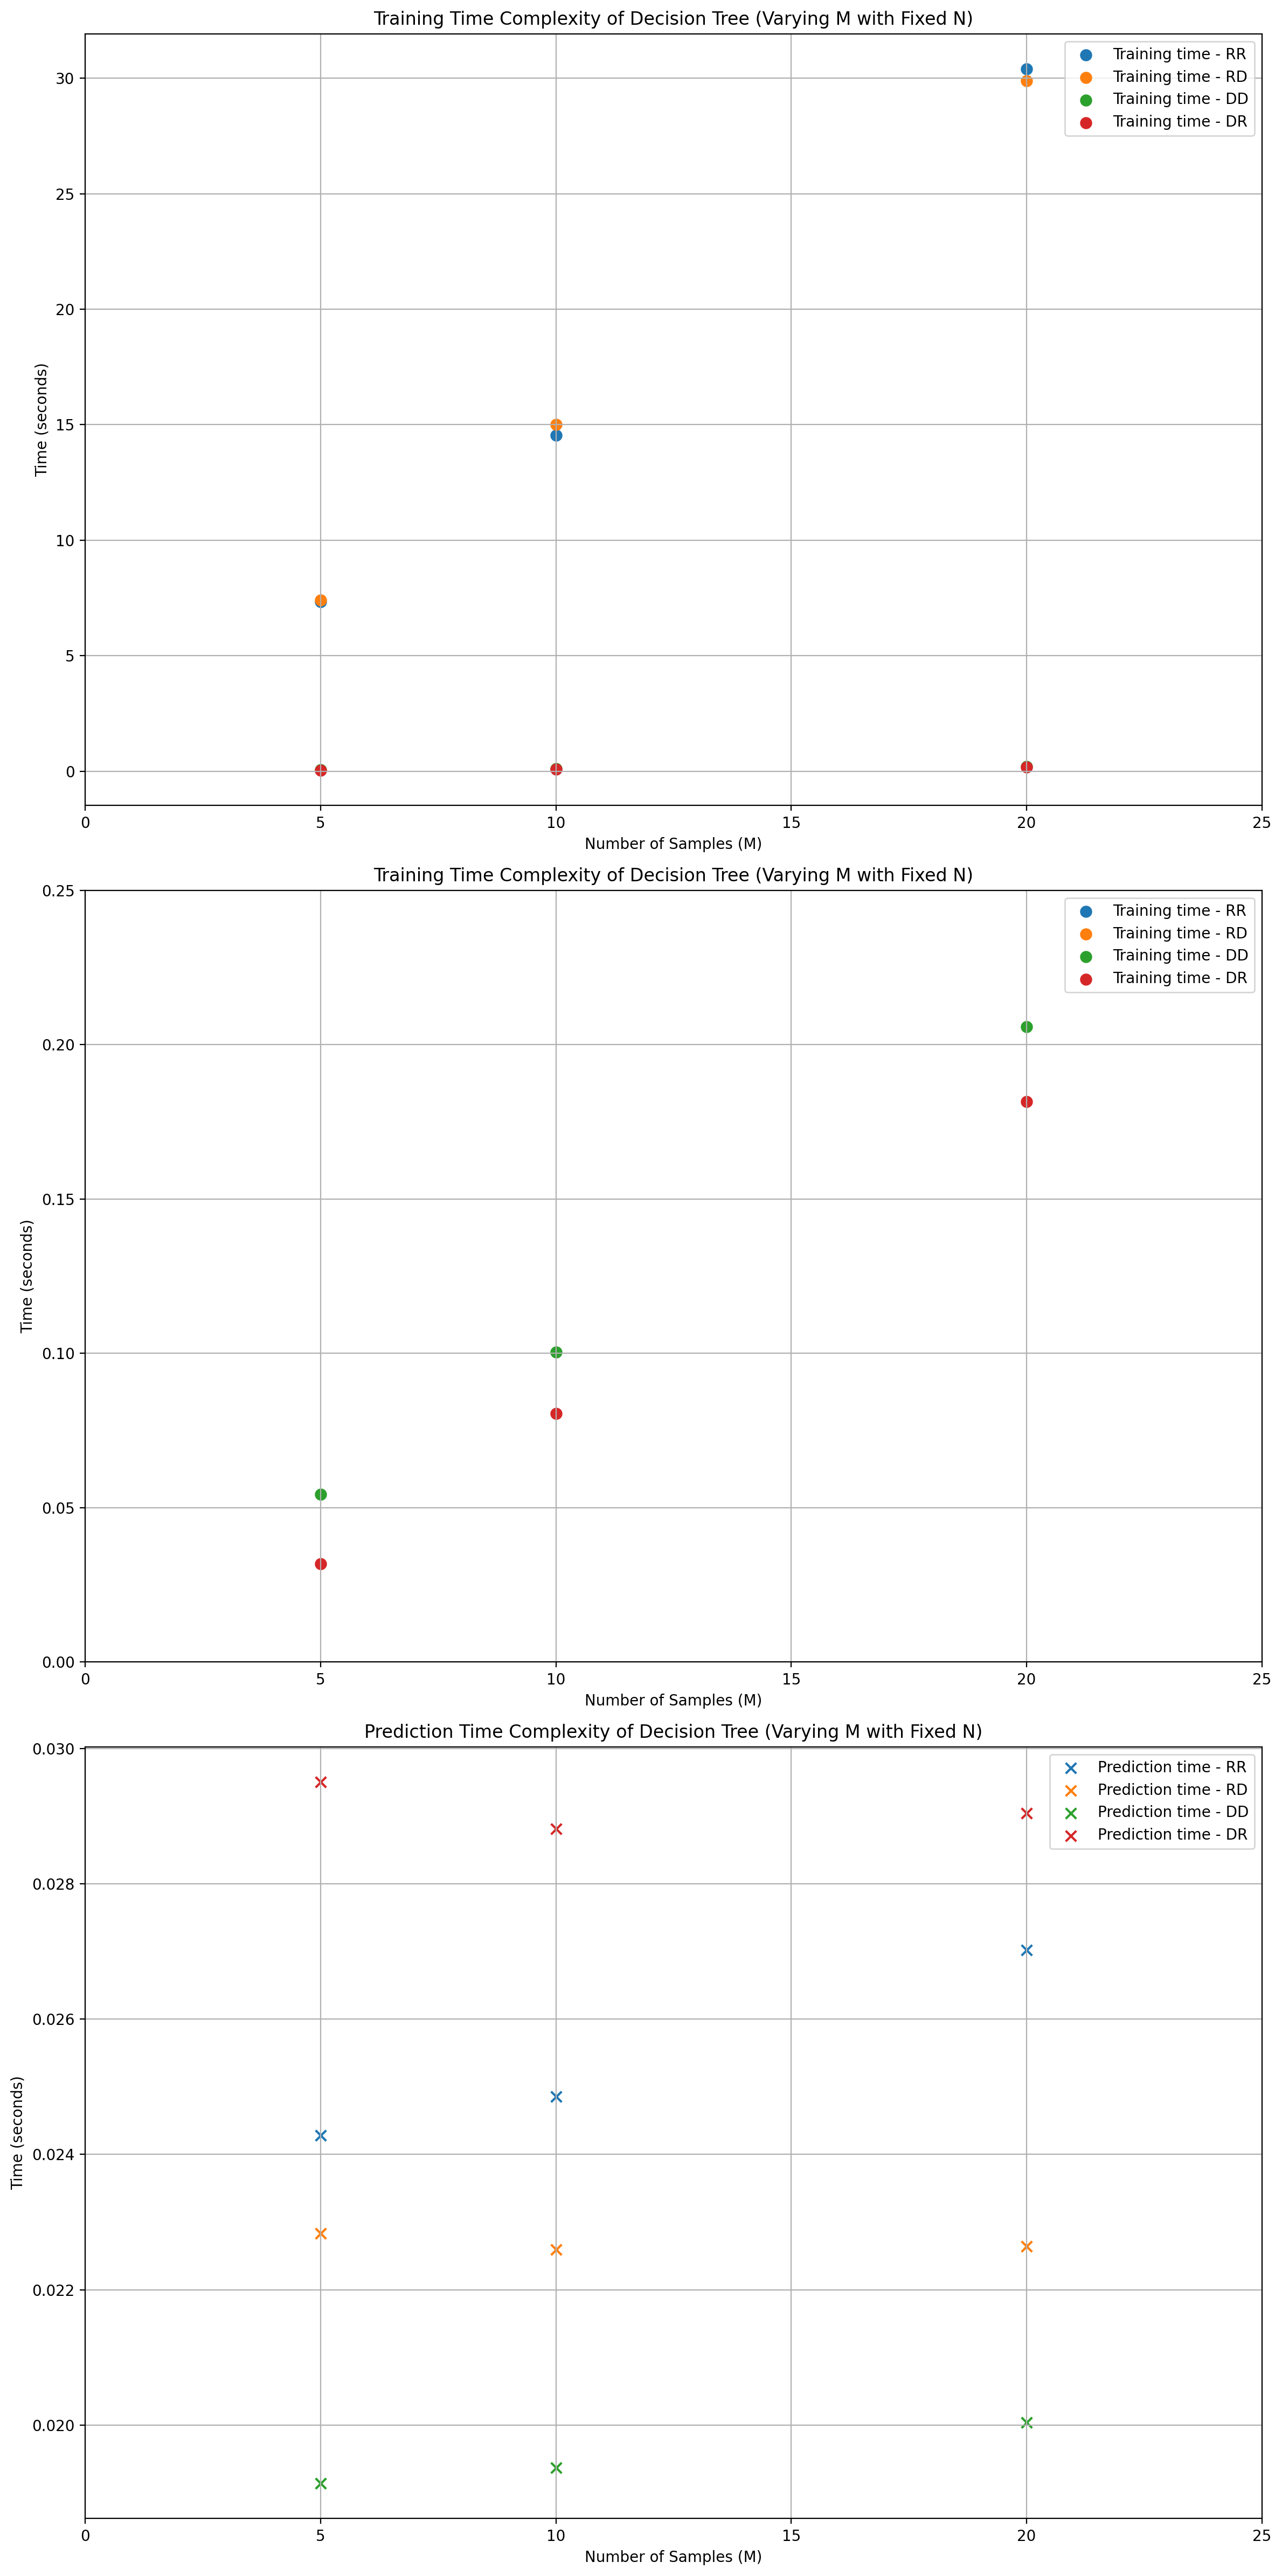

In [169]:
# Define N and M with appropriate ranges for second case
import time
N_values = [1000]  # Keeping N fixed for this plot
M_values = [5, 10, 20]

# Initialize dictionaries to store training and prediction times
train_times = {'RR': [], 'RD': [], 'DD': [], 'DR': []}
predict_times = {'RR': [], 'RD': [], 'DD': [], 'DR': []}

# Loop over different values of M
for M in M_values:
    N = N_values[0]  # Fix N
    
    # Lists to store times for three iterations
    train_times_iter = {'RR': [], 'RD': [], 'DD': [], 'DR': []}
    predict_times_iter = {'RR': [], 'RD': [], 'DD': [], 'DR': []}

    for _ in range(3):  # Run the experiments three times
        # Generate datasets
        X_real = pd.DataFrame(np.random.randn(N, M))  # Real inputs
        y_real = pd.Series(np.random.randn(N))  # Real outputs
        X_discrete = pd.DataFrame(np.random.randint(0, 2, size=(N, M)))  # Discrete inputs
        y_discrete = pd.Series(np.random.randint(0, 2, size=N))  # Discrete outputs

        # Initialize the DecisionTree objects for each case
        tree_rr = DecisionTree(criterion='mse', max_depth=5)  # Real input, Real output
        tree_rd = DecisionTree(criterion='gini', max_depth=5)  # Real input, Discrete output
        tree_dd = DecisionTree(criterion='gini', max_depth=5)  # Discrete input, Discrete output
        tree_dr = DecisionTree(criterion='mse', max_depth=5)  # Discrete input, Real output

        # Measure training time
        start_time = time.time()
        tree_rr.fit(X_real, y_real)
        train_times_iter['RR'].append(time.time() - start_time)

        start_time = time.time()
        tree_rd.fit(X_real, y_discrete)
        train_times_iter['RD'].append(time.time() - start_time)

        start_time = time.time()
        tree_dd.fit(X_discrete, y_discrete)
        train_times_iter['DD'].append(time.time() - start_time)

        start_time = time.time()
        tree_dr.fit(X_discrete, y_real)
        train_times_iter['DR'].append(time.time() - start_time)

        # Measure prediction time
        start_time = time.time()
        tree_rr.predict(X_real)
        predict_times_iter['RR'].append(time.time() - start_time)

        start_time = time.time()
        tree_rd.predict(X_real)
        predict_times_iter['RD'].append(time.time() - start_time)

        start_time = time.time()
        tree_dd.predict(X_discrete)
        predict_times_iter['DD'].append(time.time() - start_time)

        start_time = time.time()
        tree_dr.predict(X_discrete)
        predict_times_iter['DR'].append(time.time() - start_time)
    
    # Calculate the mean of three iterations and store it
    for key in train_times.keys():
        train_times[key].append(np.mean(train_times_iter[key]))
        predict_times[key].append(np.mean(predict_times_iter[key]))
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
# Plot the results for varying M with the first plot having ylim(0, 1)
plt.figure(figsize=(12, 24))  # Adjust the height to accommodate the extra plot

# First subplot with ylim(0, 1)
plt.subplot(3, 1, 2)  # Change to 3 rows to add the new plot
for key in train_times.keys():
    plt.scatter(M_values, train_times[key], label=f'Training time - {key}', marker='o', s=50)
plt.xlabel('Number of Samples (M)')
plt.ylabel('Time (seconds)')
plt.title('Training Time Complexity of Decision Tree (Varying M with Fixed N)')
plt.xlim(0, 25)  # Adjust x-axis limits to fit M values
plt.ylim(0, 0.25)  # Set y-axis limits from 0 to 1
plt.legend()
plt.grid(True)

# Second subplot with no ylim (or different ylim)
plt.subplot(3, 1, 1)  
for key in train_times.keys():
    plt.scatter(M_values, train_times[key], label=f'Training time - {key}', marker='o', s=50)
plt.xlabel('Number of Samples (M)')
plt.ylabel('Time (seconds)')
plt.title('Training Time Complexity of Decision Tree (Varying M with Fixed N)')
plt.xlim(0, 25)  # Adjust x-axis limits to fit M values
plt.legend()
plt.grid(True)

# Third subplot for prediction times
plt.subplot(3, 1, 3) 
for key in predict_times.keys():
    plt.scatter(M_values, predict_times[key], label=f'Prediction time - {key}', marker='x', s=50)
plt.xlabel('Number of Samples (M)')
plt.ylabel('Time (seconds)')
plt.title('Prediction Time Complexity of Decision Tree (Varying M with Fixed N)')
plt.xlim(0, 25)  # Adjust x-axis limits to fit M values
plt.legend()
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

__Constant N:__

**Training Time:**
The training time for all cases almost doubles from 5 samples to 10 samples, and from 10 samples to 20 samples, consistent with **O(M)** for constant N

Interestingly, it can be seen that the time taken in a **decreasing order is as follows: RR ~ RD > DD > DR**. 

**Prediction Time:**
Time taken for prediction is almost the same for all cases, as it should be, as it depends only on N. 

Interestingly, it can be seen that the time taken in a **decreasing order is as follows: DR > RR > RD > DD**. Predicting real outputs(regressioon problems) take more time than for categorical data.

**Overall:**
Training time consistent with **O(M)** for constant N for all the 4 cases, consistent with theoretical results.
Prediction time follows **O(1)** for constant N for all the 4 cases, consistent with theoretical results.